## Goal

Predict the peformance of student in test (i.e. JAMB_Score)

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('jamb_exam_results.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

# remove certain column
if 'student_id' in df.columns:
    df = df.drop(columns='student_id')

# find columns with missing values
print('missing values count:\n', df.isna().sum())
# fill missing values
df = df.fillna(0)

missing values count:
 jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

seed = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [5]:
# reset the index
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# save the target value
y_full_train = df_full_train.jamb_score.values
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

# delete the target value
del df_full_train['jamb_score']
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [6]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
dv.get_feature_names_out()

array(['access_to_learning_materials=No',
       'access_to_learning_materials=Yes', 'age', 'assignments_completed',
       'attendance_rate', 'distance_to_school', 'extra_tutorials=No',
       'extra_tutorials=Yes', 'gender=Female', 'gender=Male',
       'it_knowledge=High', 'it_knowledge=Low', 'it_knowledge=Medium',
       'parent_education_level', 'parent_education_level=Primary',
       'parent_education_level=Secondary',
       'parent_education_level=Tertiary', 'parent_involvement=High',
       'parent_involvement=Low', 'parent_involvement=Medium',
       'school_location=Rural', 'school_location=Urban',
       'school_type=Private', 'school_type=Public',
       'socioeconomic_status=High', 'socioeconomic_status=Low',
       'socioeconomic_status=Medium', 'study_hours_per_week',
       'teacher_quality'], dtype=object)

### Q1

In [7]:
from sklearn.tree import DecisionTreeRegressor

# create the model 
model = DecisionTreeRegressor(max_depth = 1, random_state=seed)

# train the model
model.fit(X_train, y_train)

# dict vectorize the validation dataset
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# use validation dataset to do the prediction
y_pred = model.predict(X_val)

In [8]:
importance = list(zip(dv.feature_names_, model.feature_importances_))

df_importance = pd.DataFrame(importance, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
27,study_hours_per_week,1.0
1,access_to_learning_materials=Yes,0.0
2,age,0.0
3,assignments_completed,0.0
0,access_to_learning_materials=No,0.0
5,distance_to_school,0.0
6,extra_tutorials=No,0.0
7,extra_tutorials=Yes,0.0
8,gender=Female,0.0
9,gender=Male,0.0


### Q2

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_val, y_pred)

42.13724207871227

### Q3

In [20]:
from tqdm import tqdm

scores = []

for i in tqdm(np.arange(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append(round(root_mean_squared_error(y_val, y_pred),2))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:54<00:00,  5.73s/it]


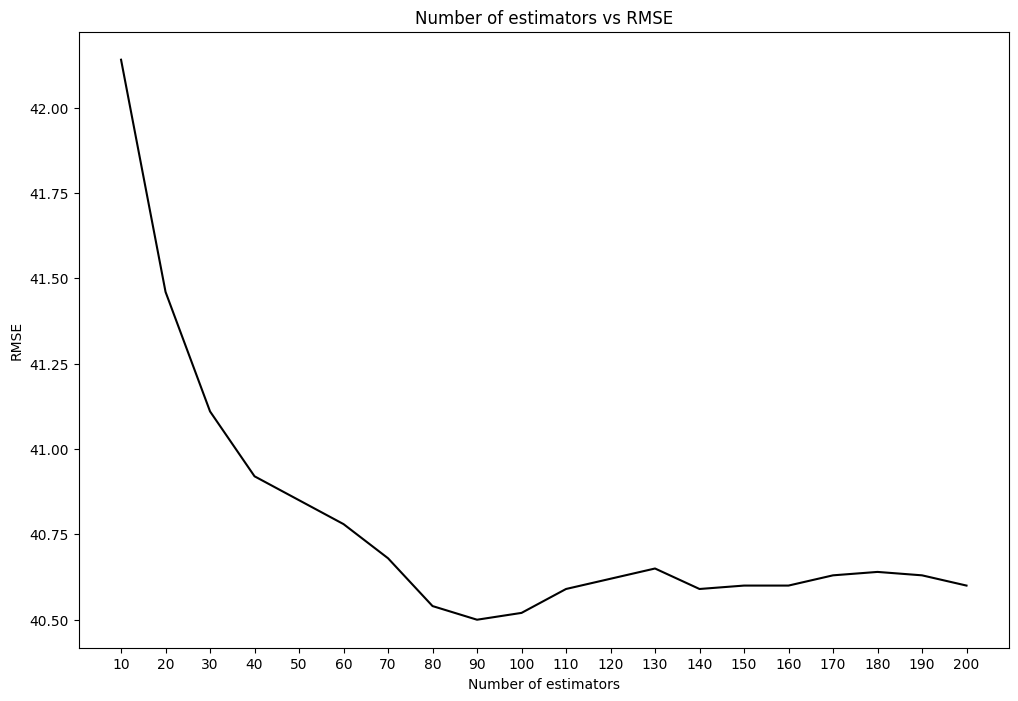

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(np.arange(10, 201, 10), scores, color='black')
plt.xticks(np.arange(10, 201, 10))

plt.title('Number of estimators vs RMSE')
plt.xlabel('Number of estimators')
plt.ylabel('RMSE')

plt.show()

### Q4

In [28]:
max_depth = [10, 15, 20, 25]
all_scores = {}
for i in tqdm(max_depth):
    print('depth: %s' % i)
    scores = []
    for j in np.arange(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=j, max_depth=i, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append(root_mean_squared_error(y_val, y_pred))
    all_scores[i] = np.mean(scores)
    print('%s -> %.2f'%(i, np.mean(scores)) )
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

depth: 10


 25%|██▌       | 1/4 [00:57<02:51, 57.24s/it]

10 -> 40.39

depth: 15


 50%|█████     | 2/4 [02:40<02:48, 84.10s/it]

15 -> 40.74

depth: 20


 75%|███████▌  | 3/4 [04:32<01:37, 97.15s/it]

20 -> 40.74

depth: 25


100%|██████████| 4/4 [06:23<00:00, 95.97s/it] 

25 -> 40.79



### Q5

In [29]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importance = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importance, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


### Q6

In [ ]:
def parse_xgb_output(output):
    tree = []
    rmse_train = []
    rmse_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        rmse_train.append(train)
        rmse_val.append(val)

    return tree, rmse_train, rmse_val

In [34]:
# !pip install xgboost
import xgboost as xgb

In [ ]:
# create dmatrix for train & val
dtrain_reg = xgb.DMatrix(X_train, y_train, feature_names=dv.feature_names_)
dval_reg = xgb.DMatrix(X_val, y_val, feature_names=dv.feature_names_)

In [52]:
# set parms (eta=0.3)
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# create watchlist
evallist = [(dtrain_reg, 'train'), (dval_reg, 'val')]


In [53]:
%%capture output

# train the model
model = xgb.train(xgb_params, dtrain_reg, num_boost_round=100, evals=evallist, verbose_eval=10)

tree, rmse_train_03, rmse_val_03 = parse_xgb_output(output)

In [54]:
# set parms (eta=0.1)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# create watchlist
evallist = [(dtrain_reg, 'train'), (dval_reg, 'val')]

In [55]:
%%capture output

# train the model
model = xgb.train(xgb_params, dtrain_reg, num_boost_round=100, evals=evallist, verbose_eval=10)

tree, rmse_train_01, rmse_val_01 = parse_xgb_output(output)

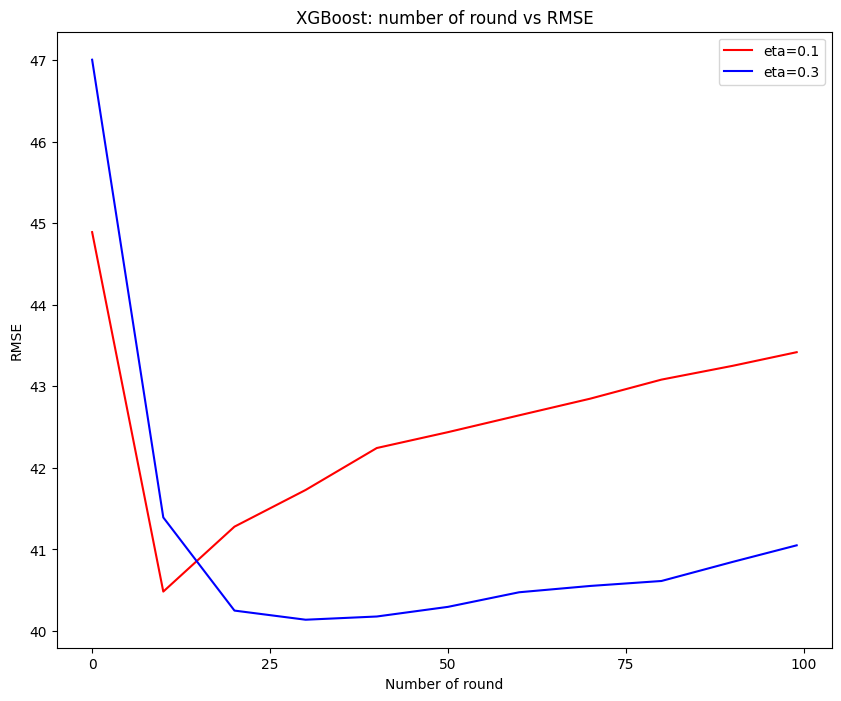

In [57]:
plt.figure(figsize=(10, 8))

plt.plot(tree, rmse_val_01, color='red', linestyle='solid', label='eta=0.1')
plt.plot(tree, rmse_val_03, color='blue', linestyle='solid', label='eta=0.3')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of round vs RMSE')
plt.xlabel('Number of round')
plt.ylabel('RMSE')

plt.show()